In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import HTML
from matplotlib import animation

%matplotlib inline

In [2]:
gpe = 100         # gridpoints in eccentricity
gps = 80          # gridpoints in size

sMin = -4    
sMax = 8

eMin = 0.0    
eMax = 0.2

size = np.linspace(sMin,sMax,gps)
eccs = np.linspace(eMin,eMax,gpe)

# if all results have same strength law, it is convenient to fill it in here

A_stg = 5e7      # strength constant A in erg g^-1
B_stg = 3.3e-8    # strength constant B
s_small = 0            # size_0 of strength eq = 1 cm in log cm
alp_stg = -0.3    # strength constant alpha
bet_stg = 2       # strength constant beta

rho = 1
mass = np.log10(rho*1*np.pi/3) + 3*size  # log mass in g

asp_rat = (sMax-sMin)/(eMax-eMin)   # aspect ratio for plotting grid

G = 4*np.pi**2          # gravitational constant
sma = 45                # semimajor axis in au
h = 1                   # disk scale height h = 1 AU
mE = 5.972e27           # mass of Earth in g
vkep = np.sqrt(G/sma) * (1.5e11/3.15e7)     # keplerian velocity in m s^-1

def unpack(res, ge = gpe, gs = gps):
    N = np.load('%s/N.npy' %res)
    N_i = np.load('%s/N_i.npy' %res)
    N_o = np.load('%s/N_o.npy' %res)
    ts = np.load('%s/ts.npy' %res)
    dt = np.load('%s/dt.npy' %res)
    fu = np.load('%s/fu.npy' %res)

    steps_track = len(N)
    steps_integ = len(dt)
    print(res, 'took', steps_integ,'steps')
        
    N = N.reshape(steps_track,ge,gs)
    N_i = N_i.reshape(steps_track,ge,gs)
    N_o = N_o.reshape(steps_track,ge,gs)

    Ndot = 10**N_i - 10**N_o

    return N, N_i, N_o, Ndot, ts, dt, fu

def qstar(s1, A = A_stg, B = B_stg, alp = alp_stg, bet = bet_stg, s0 = s_small):
    term1 = A * np.power(10,(s1-s0)*alp)
    term2 = B * rho * np.power(10,(s1-s0)*bet)
    return term1 + term2

def efault(s, A = A_stg, B = B_stg, alp = alp_stg, bet = bet_stg):
    Q_ = qstar(s,A,B,alp,bet)/10000    # /10000 converts from cm^2/s^2 to m^2/s^2
    efail = np.sqrt(2*Q_)/vkep
    return efail

def mass_underline(numbers, A=A_stg, B=B_stg, alp=alp_stg, bet=bet_stg, step='all'):
    """
    Calculate total mass under the cricical line, below which it cannot be quickly destroyed
    
    In: numbers -- ts-by-gpe-by-gps array; 3D array with numbers in each 2D bin at each timestep
        A, B, alp, bet -- floats; parameters of strength law used for this integration
        step -- 'all' or int; either all the timesteps or a particular one
        
    Out: mass_under -- float or array; total mass under the line at desired steps
    """
    efail = efault(size, A, B, alp, bet)  
    e_max = np.zeros(gps)
    mask = np.zeros((gpe,gps))
    
    # calculate max ecc bin at each size that is under this curve
    #   in our mask grid, set the cells under this one == 1
    
    cutoff = np.argmin(efail)
    for i in range(cutoff):
        e_max_it = np.argmin(abs(efail[i] - eccs))
        e_max[i] = e_max[i]
        
        mask[:e_max_it, i] = 1 
    
    if step == 'all':
        mass_under = np.zeros(len(numbers))
        for t in range(len(numbers)):
            num = 10**numbers[t]
            num_mask = num*mask
            mass_grid =  num_mask* 10**mass
            mass_under[t] = np.nansum(mass_grid)
            
    else:
        num = 10**numbers[step]
        num_mask = num*mask
        mass_grid =  num_mask* 10**mass
        mass_under = np.nansum(mass_grid)
            
    return mass_under

def opacity(numbers, step='all'):
    """
    calculate opacity at a certain step of an evolution of our numbers array
    
    In: numbers -- ts-by-gpe-by-gps array; 3D array with numbers in each 2D bin at each timestep
        step -- 'all' or int; either all the timesteps or a particular one
        
    Out: opacity -- float or array; opacity at selected timesteps
    """
    if step == 'all':
        opacity = np.zeros(len(numbers))
        for t in range(len(numbers)):
            for i, e in enumerate(eccs):
                N_sizes = 10**numbers[t,i]
                h = 2 * e * sma
                N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
                opacity[t] += np.nansum(N_scale)
    else:
        N_sizes = np.nansum(10**numbers[step],axis=0)
        N_scale = N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2)
        opacity = np.nansum(N_scale)
        
    return opacity

In [3]:
resdirlist1 = ['A_stg_5e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.15_t-5.0Myr_m0-10Me_p-100_r-10']

efail_A5e7 = efault(size, A = 5e7)

A_stg_5e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10 took 762 steps
A_stg_5e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10 took 7338 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_9966/648528706.py:9: RuntimeWarning: divide by zero encountered in log10
  M = np.log10(4/3*np.pi * 10**(size*3) * 10**N[-1]/mE)


A_stg_5e7/results/e0-0.15_t-5.0Myr_m0-10Me_p-100_r-10 took 2331 steps


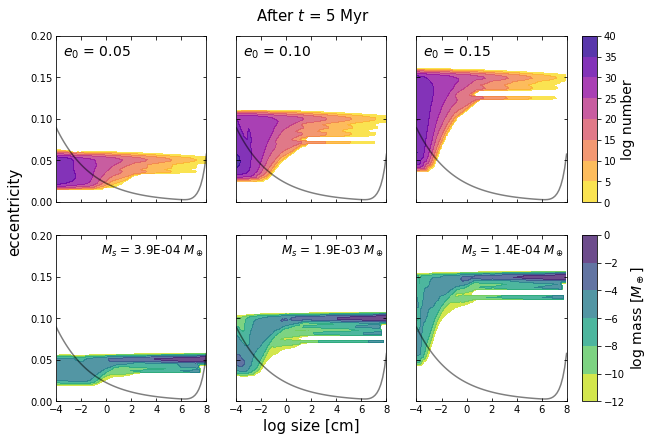

In [10]:
integs = len(resdirlist1)

fig, ax = plt.subplots(2,integs,figsize=(integs*3+1.5,7),sharex=True,sharey=True)

numbcontours = np.linspace(0,40,9)
masscontours = np.linspace(-12,0,7)
for i,d in enumerate(resdirlist1):
    N, _, _, _, _, _, _ = unpack(d)
    M = np.log10(4/3*np.pi * 10**(size*3) * 10**N[-1]/mE)
    na = ax[0,i].contourf(N[-1], origin='lower',cmap='plasma_r',alpha=.8,levels=numbcontours,extent=(sMin,sMax,eMin,eMax))
    nb = ax[1,i].contourf(M,origin='lower',cmap='viridis_r',alpha=.8,levels=masscontours,extent=(sMin,sMax,eMin,eMax))
    
    munder = mass_underline(N, step=-1)/mE
    ax[1,i].text(7.8,.19, r'$M_s$ = %1.1E $M_\oplus$' %munder, va='top',ha='right',fontsize=12)
    
for i in range(2):
    for n in range(integs):
        ax[i,n].plot(size,efail_A5e7,c='k',alpha=.5)
        ax[i,n].set_yticks([0,.05,.10,.15,.20])
        ax[i,n].set_xticks([-4,-2,0,2,4,6,8])
        ax[i,n].set_ylim(eMin,eMax)
        ax[i,n].set_xlim(sMin,sMax)
        ax[i,n].tick_params(axis='both',direction='in',right=True,top=True)

#ax[0,0].text(-3.5,.19,'Number distribution', fontsize=13,va='top')
#ax[1,0].text(-3.5,.19,'Mass distribution',fontsize=13,va='top')

ax[0,0].text(-3.5,.19,r'$e_0$ = 0.05', fontsize=14,va='top')
ax[0,1].text(-3.5,.19,r'$e_0$ = 0.10', fontsize=14,va='top')
ax[0,2].text(-3.5,.19,r'$e_0$ = 0.15', fontsize=14,va='top')

ax[1,1].set_xlabel('log size [cm]',fontsize=15)

fig.text(0.07,.42,'eccentricity',fontsize=15,rotation=90,ha='center')

fig.subplots_adjust(right=0.8)
fig.subplots_adjust(top=0.85)
cbar_ax1 = fig.add_axes([.82, 0.52, 0.02, 0.33])
cb1 = fig.colorbar(na, cax=cbar_ax1)
cb1.set_label(label = 'log number',size=14) 

cbar_ax2 = fig.add_axes([.82, 0.125, 0.02, 0.33])
cb2 = fig.colorbar(nb, cax=cbar_ax2)
cb2.set_label(label = r'log mass [$M_\oplus$]',size=14) 

fig.text(.465,.88, r'After $t$ = 5 Myr',fontsize=15, ha='center')

#fig.tight_layout()
fig.savefig('frames_10ME_A5e7.png',dpi=300)